# 5. Influence factors: Soil Properties


In [1]:
#!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil-properties

In [2]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil-properties'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil-properties


In [3]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [4]:
from qiime2 import Visualization
import qiime2 as q2
from qiime2 import Artifact
from qiime2 import Metadata
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.feature_table.methods import (filter_samples, filter_seqs)
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import prince # for MFA 
from skbio.stats.ordination import cca



from qiime2.plugins import diversity as q2d

%matplotlib inline

# Colinearlity between variables

## Using all variables shows how strongly co-linear many of them are!

In [6]:
md_soil = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv', sep='\t')

md_soil_all = md_soil[['Soil_thickness', 'Soil_type', 'Soil_depth', 'Hydromorphie_code',
       'Geology', 'Gravel_Estimate', 'Organic_Matter', 'C_total', 'Clay_Percentage', 'Silt_Percentage',
       'Sand_Percentage', 'N_total', 'CN_ratio', 'pH']]


# Convert categorical columns to dummy variables
categorical_cols = ['Soil_thickness', 'Soil_type','Soil_depth', 
                    'Geology', 'Gravel_Estimate']

# Using drop_first=True to avoid collinearity (dummy variable trap)
df_dummies = pd.get_dummies(md_soil_all, columns=categorical_cols, drop_first=True)
# Convert boolean columns to integers (0 or 1)
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)
# fill NaN
df_dummies = df_dummies.fillna(df_dummies.mean())  

# Add constant column for the VIF calculation
X = add_constant(df_dummies)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show the VIF
print(vif_data)

                      Variable        VIF
0                        const   0.000000
1            Hydromorphie_code  12.317329
2               Organic_Matter        inf
3                      C_total        inf
4              Clay_Percentage        inf
5              Silt_Percentage        inf
6              Sand_Percentage        inf
7                      N_total        inf
8                     CN_ratio        inf
9                           pH   1.488363
10  Soil_thickness_colluviosol        inf
11          Soil_type_Calcique        inf
12           Soil_depth_40-100        inf
13        Soil_depth_above_150        inf
14           Geology_Colluvium        inf
15      Geology_Gravel_moraine        inf
16             Geology_Molasse        inf
17      Gravel_Estimate_medium        inf


/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


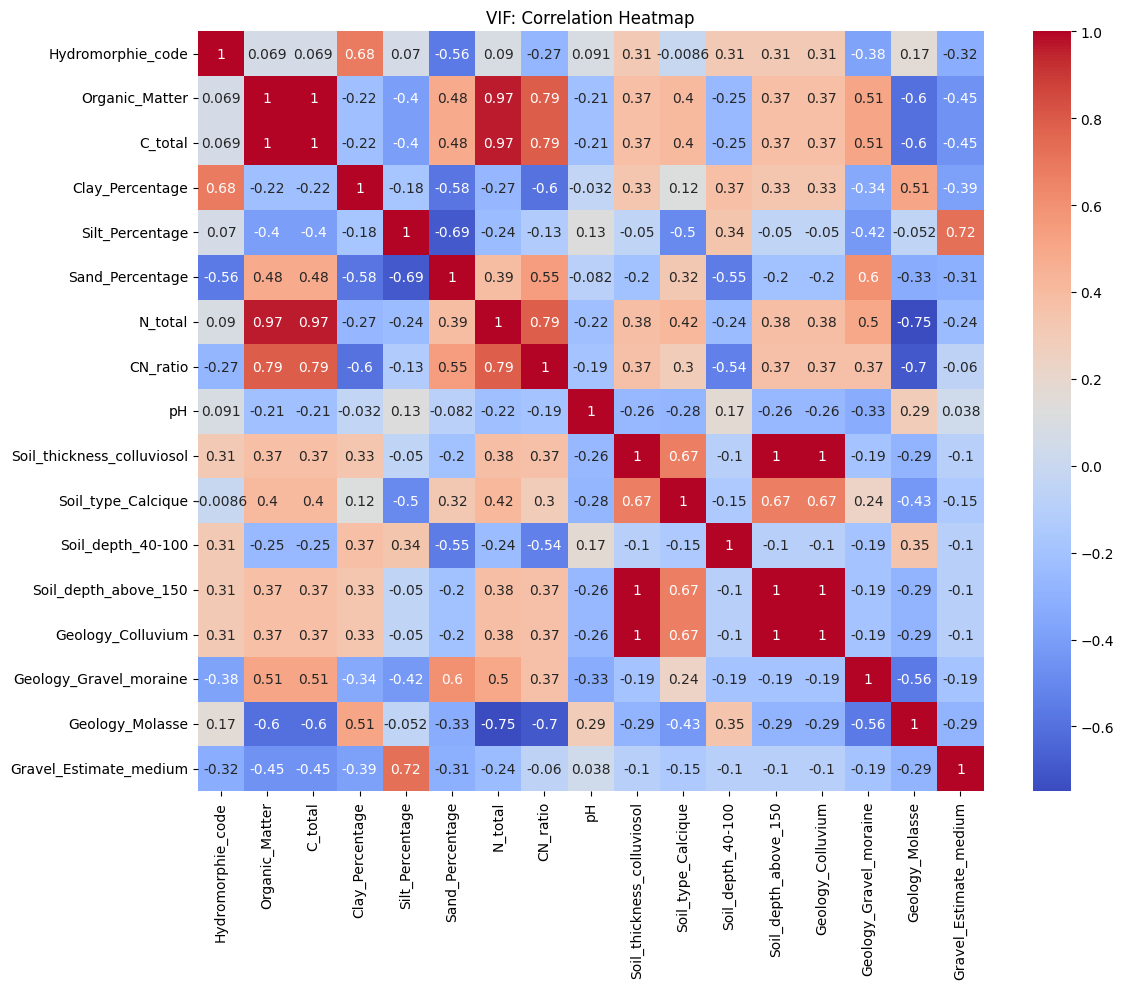

In [7]:
correlation_matrix = df_dummies.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, cbar=True)
plt.title("VIF: Correlation Heatmap")
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

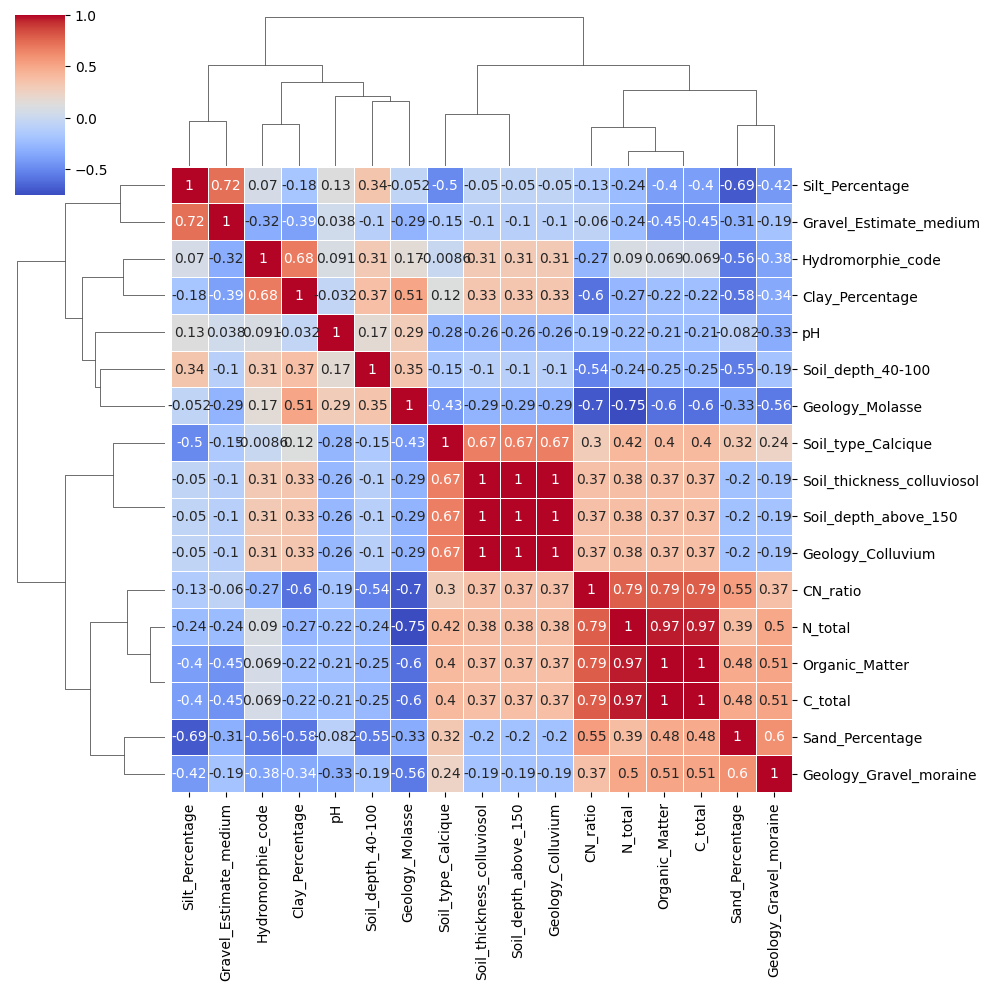

In [13]:
# Create a clustermap with hierarchical clustering
plt.figure(figsize=(10, 10))
sns.clustermap(correlation_matrix, cmap='coolwarm', annot=True, cbar=True, figsize=(10, 10),
               row_cluster=True, col_cluster=True, linewidths=0.5)# Customize the plot

# Show the plot
plt.show()

## Let's try to reduce it: 

* Soil thickness, Soil Type and Geology strongly correlate
* so do 'C_total' and 'N_total'

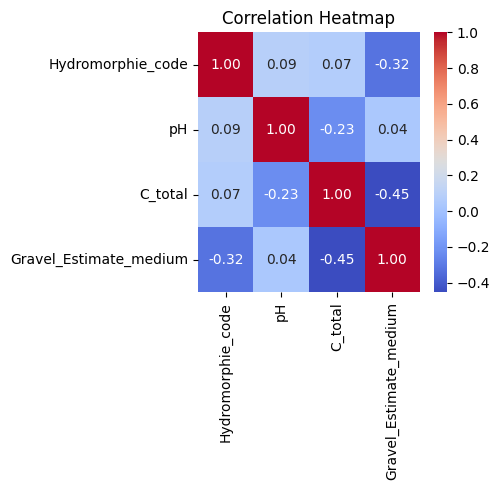

In [77]:
md_soil = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv', sep='\t')

md_soil_properties = md_soil[['Hydromorphie_code', 
'pH', 'Gravel_Estimate', 'C_total']]

# Convert categorical columns to dummy variables
categorical_cols = ['Gravel_Estimate']
df_dummies = pd.get_dummies(md_soil_properties, columns=categorical_cols, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_dummies.corr()

# Plot the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [78]:
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)
# fill NaN
df_dummies = df_dummies.fillna(df_dummies.mean())  

# Add constant column for the VIF calculation
X = add_constant(df_dummies)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show the VIF
print(vif_data)

                 Variable          VIF
0                   const  8978.335778
1       Hydromorphie_code     1.134330
2                      pH     1.059616
3                 C_total     1.322879
4  Gravel_Estimate_medium     1.406233


## Biplot

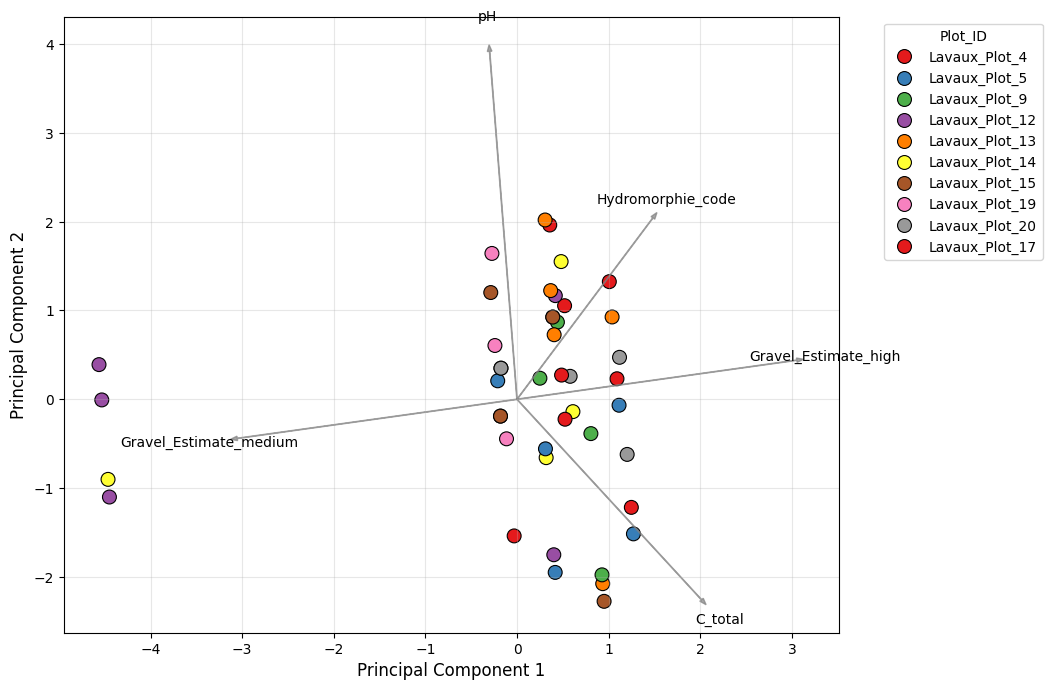

Explained Variance: PC1 = 0.49, PC2 = 0.23


In [68]:
# Prepare the data
md_soil_properties = md_soil[['Hydromorphie_code', 
'pH', 'Gravel_Estimate', 'C_total', 'id','Plot_ID']]
# Convert categorical columns to dummy variables
categorical_cols = ['Gravel_Estimate']


#md_soil_properties = md_soil[['Hydromorphie_code', 'pH', 'Gravel_Estimate', 'C_total', 'id','Plot_ID']]
#categorical_cols = [ 'Gravel_Estimate']

df_dummies = pd.get_dummies(md_soil_properties, columns=categorical_cols, drop_first=False)

# Drop rows with missing values if needed
df_dummies = df_dummies.dropna()

# Exclude SAMPLE_NAME and Plot_ID for PCA calculations
sample_names = df_dummies['id']
plot_ids = df_dummies['Plot_ID']
df_dummies = df_dummies.drop(columns=['id', 'Plot_ID'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dummies)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
pca_df['Plot_ID'] = plot_ids
pca_df['id'] = sample_names

# Biplot: Plot PCA scores (samples)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Plot_ID', s=100, edgecolor='k', palette='Set1')

# Add arrows for each feature's contribution to PC1 and PC2
# Feature loadings for PC1 and PC2
loadings = pca.components_.T  # Transpose to get variables as rows
feature_names = df_dummies.columns

# Scale the loadings for better visualization (optional)
scaling_factor = 5  # Adjust this factor to scale the arrows
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor,
              color='gray', alpha=0.7, width=0.005, head_width=0.05)
    plt.text(loadings[i, 0] * scaling_factor * 1.1, loadings[i, 1] * scaling_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}")


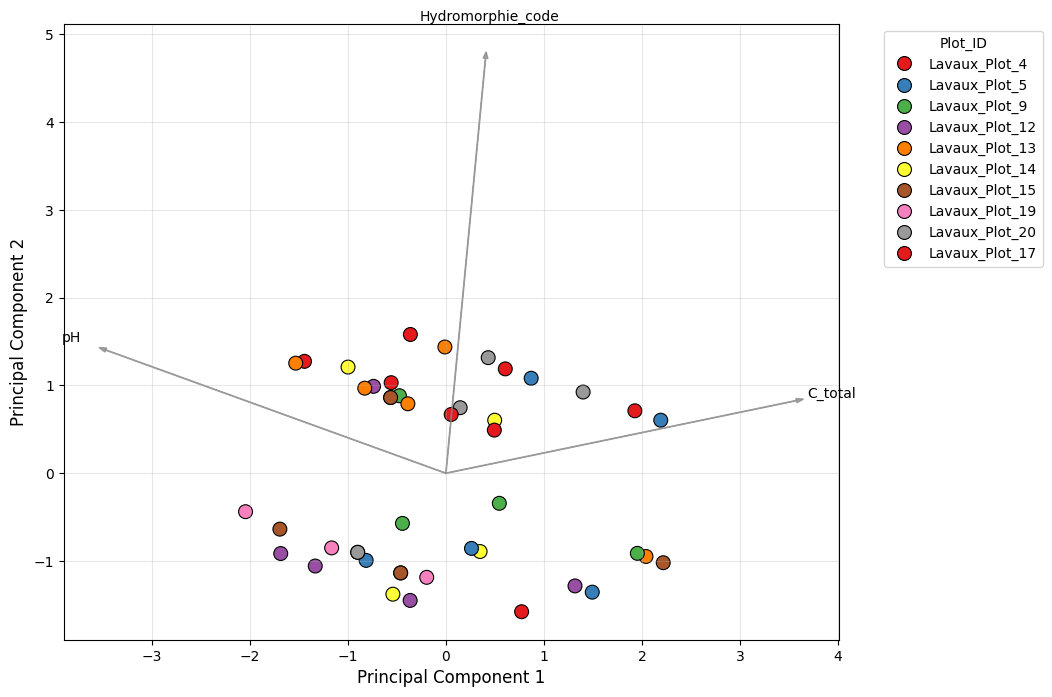

Explained Variance: PC1 = 0.41, PC2 = 0.34


In [121]:
# Prepare the data
md_soil_properties = md_soil[['Hydromorphie_code', 
'pH', 'C_total', 'id','Plot_ID']]

df_dummies = md_soil_properties.copy()

# Drop rows with missing values if needed
df_dummies = df_dummies.dropna()

# Exclude SAMPLE_NAME and Plot_ID for PCA calculations
sample_names = df_dummies['id']
plot_ids = df_dummies['Plot_ID']
df_dummies = df_dummies.drop(columns=['id', 'Plot_ID'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dummies)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
pca_df['Plot_ID'] = plot_ids
pca_df['id'] = sample_names

# Biplot: Plot PCA scores (samples)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Plot_ID', s=100, edgecolor='k', palette='Set1')

# Add arrows for each feature's contribution to PC1 and PC2
# Feature loadings for PC1 and PC2
loadings = pca.components_.T  # Transpose to get variables as rows
feature_names = df_dummies.columns

# Scale the loadings for better visualization (optional)
scaling_factor = 5  # Adjust this factor to scale the arrows
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor,
              color='gray', alpha=0.7, width=0.005, head_width=0.05)
    plt.text(loadings[i, 0] * scaling_factor * 1.1, loadings[i, 1] * scaling_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}")


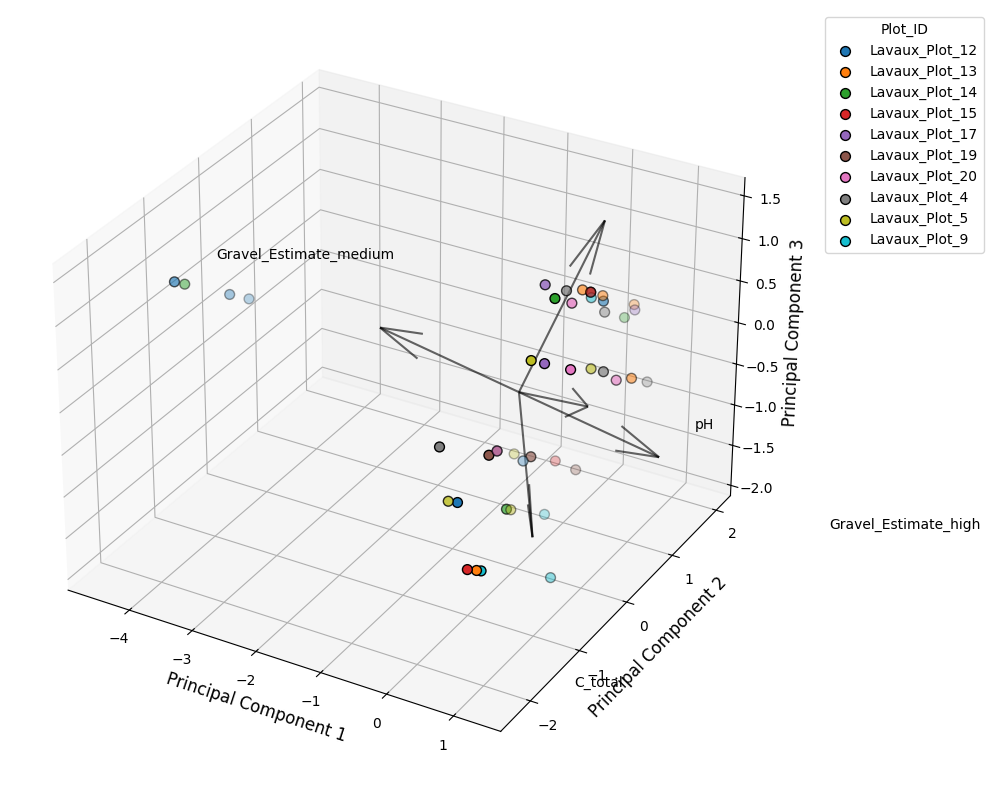

Explained Variance: PC1 = 0.49, PC2 = 0.23, PC3 = 0.16


In [69]:
# Perform PCA
pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2', 'PC3'])
pca_df['Plot_ID'] = plot_ids
pca_df['SAMPLE_NAME'] = sample_names

# Plot the PCA results with Plot_ID as hue
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for plot_id, group in pca_df.groupby('Plot_ID'):
    ax.scatter(
        group['PC1'], group['PC2'], group['PC3'], 
        label=plot_id, 
        s=50, 
        edgecolor='k'
    )

# Add the biplot: plotting the variables as vectors
for i in range(len(df_dummies.columns)):
    ax.quiver(
        0, 0, 0,  # Origin of the vector
        pca.components_[0, i], pca.components_[1, i], pca.components_[2, i],  # Vector components
        length=2,  # Length of the vector
        normalize=True,  # Normalize vectors
        color='black',  # Vector color (red)
        alpha=0.6  # Transparency
    )
    # Add the labels for each variable associated with the vectors
    ax.text(
        pca.components_[0, i] * 7, 
        pca.components_[1, i] * 6, 
        pca.components_[2, i] * 6, 
        df_dummies.columns[i],  # Variable name
        color='black', 
        fontsize=10
    )

# Customize plot
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)
ax.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}, PC3 = {explained_variance[2]:.2f}")


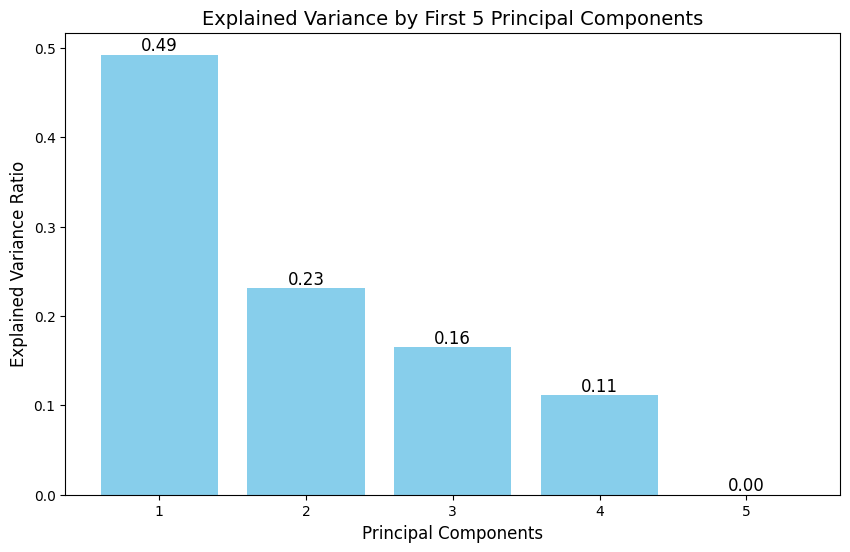

In [70]:
# Perform PCA, reduce to 5 components
pca = PCA(n_components=5)
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=[f'PC{i}' for i in range(1, 6)])
pca_df['id'] = sample_names

# Plot the explained variance ratios for the first 5 components (not 10)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 6), explained_variance[:5], color='skyblue')
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Explained Variance by First 5 Principal Components', fontsize=14)
plt.xticks(range(1, 6))

# Add the explained variance values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


# Soil microbiome PCoA

In [ ]:
%%bash

qiime feature-table filter-seqs \
        --i-data /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/Sven-denoising-test/ITS/revcomp-trimmed-denoised/with-adjusted-parameters/ITS-revcomp-trimmed-ER-0.05-denoised-trunc-190-PFA-4.0-maxee-4.0-rep-seqs.qza \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil_filtered_table.qza \
        --o-filtered-data soil_filtered_rep_seq.qza

# Core diversity metrics
qiime diversity core-metrics \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil_filtered_table.qza \
        --p-sampling-depth 5000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --p-n-jobs 5 \
        --output-dir cm5000/

# Kmer diversity
qiime kmerizer core-metrics \
        --i-sequences soil_filtered_rep_seq.qza \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil_filtered_table.qza \
        --p-sampling-depth 5000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --p-n-jobs auto \
        --output-dir kmer_cm5000/

In [ ]:
%%bash 

div_dir='cm5000'
kmer_dir='kmer_cm5000'

qiime tools export --input-path $div_dir/bray_curtis_pcoa_results.qza --output-path $div_dir/bray_curtis_pcoa_results
qiime tools export --input-path $div_dir/jaccard_pcoa_results.qza --output-path $div_dir/jaccard_pcoa_results
qiime tools export --input-path $kmer_dir/bray_curtis_pcoa_results.qza --output-path $kmer_dir/bray_curtis_pcoa_results
qiime tools export --input-path $kmer_dir/jaccard_pcoa_results.qza --output-path $kmer_dir/jaccard_pcoa_results

# CCA

In [ ]:
# merge the feature table with the taxonomy 
!qiime taxa collapse \
  --i-table cm5000/rarefied_table.qza \
  --i-taxonomy /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy.qza \
  --p-level 7 \
  --o-collapsed-table RarefiedTable-Level7-wTaxa.qza

# export rarefied table 
!qiime tools export --input-path RarefiedTable-Level7-wTaxa.qza --output-path RarefiedTable-Level7-wTaxa
!biom convert -i RarefiedTable-Level7-wTaxa/feature-table.biom -o RarefiedTable-Level7-wTaxa/feature-table.tsv --to-tsv

somehow merging with taxonomy introduces an issue

In [ ]:
!ls cm5000/rarefied_table

In [79]:
# Load the feature table
#feature_table = pd.read_csv('RarefiedTable-Level7-wTaxa/feature-table.tsv', sep='\t', skiprows=1, index_col=0)
feature_table = pd.read_csv('cm5000/rarefied_table/feature-table.tsv', sep='\t', skiprows=1, index_col=0)


# Transpose the table to have samples as rows and features as columns
feature_table = feature_table.T

print(feature_table.shape)

(44, 4268)


In [80]:
# note. cca does require some variance - so we're dropping these columns
zero_variance_cols = feature_table.var(axis=0) == 0
feature_table = feature_table.loc[:, ~zero_variance_cols]

feature_table.shape

(44, 4268)

In [81]:
md_soil = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv', sep='\t')

md_soil_properties = md_soil[['Hydromorphie_code', 
'pH', 'Gravel_Estimate', 'C_total', 'id']]
md_soil_properties.set_index('id', inplace=True)

# categorical columns
categorical_cols = ['Gravel_Estimate']
# One-hot encode categorical metadata
md_soil_properties_encoded = pd.get_dummies(md_soil_properties, columns=categorical_cols)
# Drop rows with missing values
md_soil_properties_encoded = md_soil_properties_encoded.dropna()

md_soil_properties_encoded.shape

(50, 5)

In [82]:
# Find common indices between the two datasets
common_indices = feature_table.index.intersection(md_soil_properties_encoded.index)

# Filter both dataframes to retain only rows with common indices
feature_table_aligned = feature_table.loc[common_indices]
md_soil_properties_aligned = md_soil_properties_encoded.loc[common_indices]

print(feature_table_aligned.shape)
print(md_soil_properties_aligned.shape)

(39, 4268)
(39, 5)


In [83]:
ordination = cca(feature_table_aligned, md_soil_properties_aligned_scaled)


/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/skbio/stats/ordination/_canonical_correspondence_analysis.py:133: RuntimeWarning: invalid value encountered in divide
  Q_bar = (Q - expected) / np.sqrt(expected)


ValueError: array must not contain infs or NaNs

In [ ]:
# CCA scores for each sample
sample_scores = ordination.samples

# features
feature_loadings = ordination.features

# now the metadata loadings 
biplot_loadings = ordination.biplot_scores

In [ ]:
# Step 1: Calculate the magnitude (Euclidean norm) of each feature loading vector
feature_magnitudes = np.linalg.norm(feature_loadings.values, axis=1)

# Step 2: Sort and select the top 10 feature loadings based on magnitude
top_10_feature_indices = np.argsort(feature_magnitudes)[-10:]
top_10_feature_loadings = feature_loadings.iloc[top_10_feature_indices]
top_10_feature_loadings

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the sample scores
ax.scatter(sample_scores.iloc[:, 0], sample_scores.iloc[:, 1], c='blue', label='Samples', alpha=0.6)

# Plot the feature loadings as vectors
for i in range(feature_loadings.shape[0]):
    ax.arrow(0, 0, feature_loadings.iloc[i, 0], feature_loadings.iloc[i, 1],
             color='red', alpha=0.8, head_width=0.05, head_length=0.1)
    ax.text(feature_loadings.iloc[i, 0] * 1.15, feature_loadings.iloc[i, 1] * 1.15,
            feature_loadings.index[i], color='red', fontsize=12)

# Label the axes
ax.set_xlabel('CCA1')
ax.set_ylabel('CCA2')

# Add a title
ax.set_title('Biplot of CCA', fontsize=16)

# Show the plot
plt.show()

In [ ]:
biplot_loadings

In [ ]:
ordination.biplot_scores

In [ ]:
ordination.samples

In [ ]:
# Define the feature table and metadata as inputs for CCA
ordination = cca(feature_table_aligned, md_soil_properties_aligned)

# Fit the CCA model
ordination_results = ordination.fit()

# View results
ordination_results

In [ ]:
zero_variance_cols = feature_table_aligned.var(axis=0) == 0
print("Columns with zero variance:", zero_variance_cols.sum())


In [ ]:
zero_variance_rows = feature_table_aligned.var(axis=1) == 0
print("Rows with zero variance:", zero_variance_rows.sum())


In [ ]:
zero_variance_md = md_soil_properties_aligned.var(axis=0) == 0
print("Metadata columns with zero variance:", zero_variance_md.sum())


# MFA - delete? 

In [ ]:
jaccard_kmer_pcoa = pd.read_csv('kmer_cm5000/jaccard_pcoa_results/ordination.txt', sep='\t', skiprows=8, skipfooter=3, 
                          index_col=0, usecols=[0, 1, 2])
jaccard_kmer_pcoa.columns = ['PCo1', 'PCo2', 'PCo3']

jaccard_kmer_pcoa.head()

In [ ]:
# Set the 'id' column as the index for pca_df
pca_df.set_index('id', inplace=True)
pca_df.head()

In [ ]:
# Merge pca_df and jaccard_kmer_pcoa on the indices (which are now 'id')
merged_df = pd.merge(pca_df[['PC1', 'PC2', 'PC3']], jaccard_kmer_pcoa[['PCo1', 'PCo2', 'PCo3']], left_index=True, right_index=True, how='inner')

# Create a MultiIndex for the columns to represent the groups
columns = pd.MultiIndex.from_tuples(
    [('Soil', 'PC1'), ('Soil', 'PC2'), ('Soil', 'PC3'),
     ('Jaccard', 'PCo1'), ('Jaccard', 'PCo2'), ('Jaccard', 'PCo3')]
)

# Assign the MultiIndex to the dataframe columns
merged_df.columns = columns

# Specify the groups: first 3 columns for PCA and next 3 columns for Jaccard
groups = [3, 3]  # First 3 for PCA, next 3 for Jaccard

merged_df

In [ ]:
# Perform MFA
mfa = prince.MFA(n_components=3,random_state=42)
mfa = mfa.fit(merged_df)

In [ ]:
# Get the coordinates of the MFA (this is the reduced dimensionality representation)
mfa_coords = mfa.transform(merged_df)

mfa_coords

In [ ]:
# Convert MFA coordinates to a DataFrame for easier plotting
mfa_coords_df = mfa_coords.copy()
mfa_coords_df.columns = ['Component 1', 'Component 2', 'Component 3']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mfa_coords_df['Component 1'], mfa_coords_df['Component 2'], mfa_coords_df['Component 3'], c='b', alpha=0.7)
ax.set_title("MFA: 3D Representation")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

In [ ]:
# Get variable contributions to each component
contributions = mfa.column_contributions_
contributions_df = contributions.iloc[:, :3]  # Contributions for the first 3 components
contributions_df

In [ ]:

# Visualize contributions of variables to Component 1
contributions_df[0].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Variable Contributions to Component 1")
plt.ylabel("Contribution")
plt.show()

# Soil Properties 

## PERMANOVA 

### Subset and calculate diversity 

In [ ]:
!rm -r soil-properties

In [86]:
%%bash 

mkdir soil-properties
cd soil-properties

# subset to make sure that all samples have pH measurement (they should)
qiime feature-table filter-samples \
      --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/soil_filtered_table.qza \
      --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
      --p-where "[C_total] IS NOT NULL" \
      --o-filtered-table filtered_table.qza

qiime feature-table filter-seqs \
        --i-data /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/Sven-denoising-test/ITS/revcomp-trimmed-denoised/with-adjusted-parameters/ITS-revcomp-trimmed-ER-0.05-denoised-trunc-190-PFA-4.0-maxee-4.0-rep-seqs.qza \
        --i-table filtered_table.qza \
        --o-filtered-data filtered_rep_seqs.qza

# Core diversity metrics
qiime diversity core-metrics \
        --i-table filtered_table.qza \
        --p-sampling-depth 5000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --p-n-jobs 5 \
        --output-dir cm5000/

# Kmer diversity
qiime kmerizer core-metrics \
        --i-sequences filtered_rep_seqs.qza \
        --i-table filtered_table.qza \
        --p-sampling-depth 5000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --p-n-jobs auto \
        --output-dir kmer_cm5000/

Saved FeatureTable[Frequency] to: filtered_table.qza
Saved FeatureData[Sequence] to: filtered_rep_seqs.qza
Saved FeatureTable[Frequency] to: cm5000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: cm5000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: cm5000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: cm5000/evenness_vector.qza
Saved DistanceMatrix to: cm5000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: cm5000/bray_curtis_distance_matrix.qza
Saved PCoAResults to: cm5000/jaccard_pcoa_results.qza
Saved PCoAResults to: cm5000/bray_curtis_pcoa_results.qza
Saved Visualization to: cm5000/jaccard_emperor.qzv
Saved Visualization to: cm5000/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: kmer_cm5000/rarefied_table.qza
Saved FeatureTable[Frequency] to: kmer_cm5000/kmer_table.qza
Saved SampleData[AlphaDiversity] to: kmer_cm5000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: kmer_cm5000/shannon_vector.qza
Saved DistanceMatri

In [94]:
Visualization.load('soil-properties/cm5000/bray_curtis_emperor.qzv')

<visualization: Visualization uuid: dda050d4-59dd-4835-bcd4-4dce6e60ee8c>

In [95]:
Visualization.load('soil-properties/cm5000/jaccard_emperor.qzv')

<visualization: Visualization uuid: 908c4266-a3f8-4056-a38a-2ad40e649893>

In [96]:
Visualization.load('soil-properties/kmer_cm5000/scatterplot.qzv')

<visualization: Visualization uuid: 83f89bf5-60e2-4a47-b9c0-e10e556d4aeb>

## Nicer Plots

In [88]:
!qiime tools export --input-path soil-properties/cm5000/jaccard_pcoa_results.qza --output-path soil-properties/cm5000/jaccard_pcoa
!qiime tools export --input-path soil-properties/cm5000/bray_curtis_pcoa_results.qza --output-path soil-properties/cm5000/bray_curtis_pcoa


# reimport 
bc_pcoa = pd.read_csv('soil-properties/cm5000/bray_curtis_pcoa/ordination.txt', sep='\t', skiprows=9, header=None)
jaccard_pcoa = pd.read_csv('soil-properties/cm5000/jaccard_pcoa/ordination.txt', sep='\t', skiprows=9, header=None)

# function to get components 
def select_components(df):
    # Drop the last 2 rows
    df = df.iloc[:-2]
    # Select specific columns
    df = df.iloc[:, [0, 1, 2]]
    # Rename columns and set index
    df = df.rename(columns={0: 'ID', 1: 'PC1', 2: 'PC2'}).set_index('ID')
    return df

bc_pcoa_df = select_components(bc_pcoa)
jaccard_pcoa_df = select_components(jaccard_pcoa)

Exported soil-properties/cm5000/jaccard_pcoa_results.qza as OrdinationDirectoryFormat to directory soil-properties/cm5000/jaccard_pcoa
Exported soil-properties/cm5000/bray_curtis_pcoa_results.qza as OrdinationDirectoryFormat to directory soil-properties/cm5000/bray_curtis_pcoa


In [89]:
md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv', sep='\t', index_col=0)

# merge with metadata
bc_pcoa_df_merged = bc_pcoa_df.merge(md, left_on='ID', right_on='id', how='left')
jaccard_pcoa_df_merged = jaccard_pcoa_df.merge(md, left_on='ID', right_on='id', how='left')

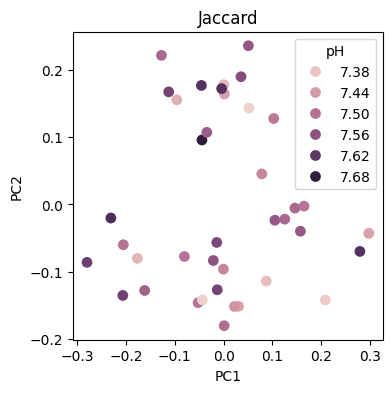

In [122]:
plt.figure(figsize=(4, 4)) 
sns.scatterplot(
    x='PC1', y='PC2',
    data=jaccard_pcoa_df_merged,
    hue='pH',
    s=60,edgecolor='none')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Jaccard')

plt.show()

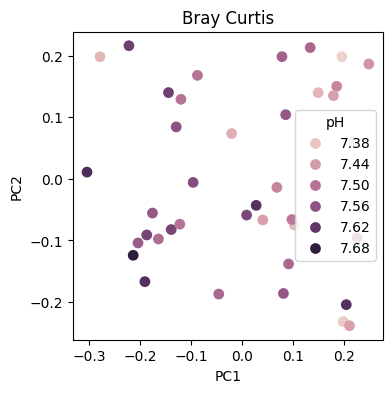

In [123]:
plt.figure(figsize=(4, 4)) 
sns.scatterplot(
    x='PC1', y='PC2',
    data=bc_pcoa_df_merged,
    hue='pH',
    s=60,edgecolor='none')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Bray Curtis')
plt.show()

### PERMANOVA thereof

In [116]:
formula = 'pH + Hydromorphie_code + C_total ' 
beta_metrics = ['bray_curtis', 'jaccard']

# PERMANOVA with core metrics 
div_dir = 'soil-properties/cm5000'
for m in beta_metrics:
    !qiime diversity adonis \
        --i-distance-matrix "{div_dir}/{m}_distance_matrix.qza" \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --p-formula "{formula}" \
        --p-n-jobs 5 \
        --o-visualization "{div_dir}/adonis_{m}.qzv"
    

# PERMANOVA with kmer core metrics 
kmer_dir = 'soil-properties/kmer_cm5000'
for m in beta_metrics:
    !qiime diversity adonis \
        --i-distance-matrix "{kmer_dir}/{m}_distance_matrix.qza" \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --p-formula "{formula}" \
        --p-n-jobs 5 \
        --o-visualization "{kmer_dir}/adonis_{m}.qzv"

Saved Visualization to: soil-properties/cm5000/adonis_bray_curtis.qzv
Saved Visualization to: soil-properties/cm5000/adonis_jaccard.qzv
Saved Visualization to: soil-properties/kmer_cm5000/adonis_bray_curtis.qzv
Saved Visualization to: soil-properties/kmer_cm5000/adonis_jaccard.qzv


In [117]:
Visualization.load('soil-properties/cm5000/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: a2bafe49-f9bd-47b8-9fbb-de49b8133fdd>

In [118]:
Visualization.load('soil-properties/cm5000/adonis_jaccard.qzv')

<visualization: Visualization uuid: f2cdd9d7-8817-4445-836c-d2c617c8fb70>

In [119]:
Visualization.load('soil-properties/kmer_cm5000/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: 425daa8c-5a1c-4681-aff1-82dd8e30ac2c>

In [120]:
Visualization.load('soil-properties/kmer_cm5000/adonis_jaccard.qzv')

<visualization: Visualization uuid: 9dcc145e-a60c-4a76-a450-c1a440f89029>

## Regress Samples

In [134]:
%%bash 

columns=('pH', 'C_total', 'Hydromorphie')

for column in "${columns[@]}"
do
    echo "Processing regression for $column"
    
    qiime sample-classifier regress-samples \
        --i-table soil-properties/filtered_table.qza \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \
        --m-metadata-column "$column" \
        --p-n-jobs 10 \
        --output-dir "soil-properties/$column"
done


Processing regression for pH,


Usage: qiime sample-classifier regress-samples [OPTIONS]

  Predicts a continuous sample metadata column using a supervised learning
  regressor. Splits input data into training and test sets. The training set
  is used to train and test the estimator using a stratified k-fold cross-
  validation scheme. This includes optional steps for automated feature
  extraction and hyperparameter optimization. The test set validates
  classification accuracy of the optimized estimator. Outputs classification
  results for test set. For more details on the learning algorithm, see
  http://scikit-learn.org/stable/supervised_learning.html

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency | RelativeFrequency |
    PresenceAbsence | Composition]
                          Feature table containing all features that should
                          be used for target prediction.            [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Numeric]
       

Processing regression for C_total,


Usage: qiime sample-classifier regress-samples [OPTIONS]

  Predicts a continuous sample metadata column using a supervised learning
  regressor. Splits input data into training and test sets. The training set
  is used to train and test the estimator using a stratified k-fold cross-
  validation scheme. This includes optional steps for automated feature
  extraction and hyperparameter optimization. The test set validates
  classification accuracy of the optimized estimator. Outputs classification
  results for test set. For more details on the learning algorithm, see
  http://scikit-learn.org/stable/supervised_learning.html

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency | RelativeFrequency |
    PresenceAbsence | Composition]
                          Feature table containing all features that should
                          be used for target prediction.            [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Numeric]
       

Processing regression for Hydromorphie


Usage: qiime sample-classifier regress-samples [OPTIONS]

  Predicts a continuous sample metadata column using a supervised learning
  regressor. Splits input data into training and test sets. The training set
  is used to train and test the estimator using a stratified k-fold cross-
  validation scheme. This includes optional steps for automated feature
  extraction and hyperparameter optimization. The test set validates
  classification accuracy of the optimized estimator. Outputs classification
  results for test set. For more details on the learning algorithm, see
  http://scikit-learn.org/stable/supervised_learning.html

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency | RelativeFrequency |
    PresenceAbsence | Composition]
                          Feature table containing all features that should
                          be used for target prediction.            [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Numeric]
       

CalledProcessError: Command 'b'\ncolumns=(\'pH\', \'C_total\', \'Hydromorphie\')\n\nfor column in "${columns[@]}"\ndo\n    echo "Processing regression for $column"\n    \n    qiime sample-classifier regress-samples \\\n        --i-table soil-properties/filtered_table.qza \\\n        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Soil.tsv \\\n        --m-metadata-column "$column" \\\n        --p-n-jobs 10 \\\n        --output-dir "soil-properties/$column"\ndone\n'' returned non-zero exit status 1.

In [ ]:
Visualization.load('soil-properties/pH/accuracy_results.qzv')

In [ ]:
Visualization.load('soil-properties/C_total/accuracy_results.qzv')